# Import Libraries

In [1]:
import datasets
import transformers
import pandas as pd
import torch
from torch.utils.data.dataset import Dataset
from pathlib import Path



#Tokenizer from scratch on vocabulary of corpus
from tokenizers import ByteLevelBPETokenizer

# Decoder
from transformers import RobertaConfig
from transformers import RobertaForMaskedLM # RobertaLM for learning
from transformers import RobertaTokenizerFast # After training tokenizern we will wrap it so it can be used by Roberta model



#Encoder-Decoder Model
from transformers import VisionEncoderDecoderModel

#Training
# When using previous version of the library you need the following two lines
from transformers import Seq2SeqTrainer
from transformers import Seq2SeqTrainingArguments
from transformers import Trainer, TrainingArguments

# Parameters for Training

In [7]:
TRAIN_BATCH_SIZE = 20   # input batch size for training (default: 64)
VALID_BATCH_SIZE = 5   # input batch size for testing (default: 1000)
VAL_EPOCHS = 1 
LEARNING_RATE = 1e-4    # learning rate (default: 0.01)
SEED = 42               # random seed (default: 42)
MAX_LEN = 128           # Max length for product description
SUMMARY_LEN = 20         # Max length for product names

TRAIN_EPOCHS = 2       # number of epochs to train (default: 10)
WEIGHT_DECAY = 0.01
SEED = 42               # random seed (default: 42)
MAX_LEN = 128
SUMMARY_LEN = 20   # Maximum length of caption generated by the model

# Preparing the Dataset

In [2]:
import os
os.chdir(r'C:\Users\kalpe\Dropbox\PC\Documents\Great lakes\ML project')
import json


with open('data.json', 'r') as openfile:

    json_object = json.load(openfile)

images_caption_dict = dict(json_object)


images_path = 'C:/Users/kalpe/Documents/Great lakes/ML project/Flickr8k_Dataset/Flicker8k_Dataset/'
images = list(images_caption_dict.keys())

for image_path in images:
    if image_path.endswith('jpg'):
        new = images_path + image_path.split('/')[-1]
        images_caption_dict[new] = images_caption_dict.pop(image_path)
    else:
        images_caption_dict.pop(image_path)

# Encoder (ViT) -  Decoder (Roberta)

### Train Test Split

In [3]:
import random 
def train_test_split(dictionary):
    images = dictionary.keys()
    images_test = random.sample(images,int(0.3*len(images)))
    images_train = [img for img in images if img not in images_test]

    train_dict = {
      img: dictionary[img] for img in images_train
    }

    test_dict = {
      img: dictionary[img] for img in images_test
    }
    return(train_dict,test_dict)

train,test = train_test_split(images_caption_dict)

### Creating Dataframe for Training

In [4]:
import pandas as pd

def get_df(dictionary):
    df = pd.DataFrame([])

    captions = []
    images = []
    for image in list(images_caption_dict.keys()):
        caption = images_caption_dict[image]
    #     captions.append(('.'.join([ sent.rstrip() for sent in ('.'.join(caption)).split('<e>.<s>')]))\
    #                             .replace('<s> ','').replace('  <e>','.'))
        for capt in caption:
            captions.append(' '.join(capt.replace('<s> ','').replace('  <e>','').strip().split(' ')[:30]))
            images.append(image)

    df['images'] = images
    df['captions'] = captions
    return(df)

train_df = get_df(train)
test_df = get_df(test)

### Intializing Decoder Tokenizer

In [8]:
from transformers import RobertaTokenizerFast
tokenizer = RobertaTokenizerFast.from_pretrained('Byte_tokenizer', max_len=MAX_LEN)

### Intializing ViT Feature Extractor

In [9]:
from transformers import ViTFeatureExtractor, ViTModel
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")

### Creating Dataset for training (The number of training samples wre limited due to processing restrictions)

In [10]:
import torch
from torch.utils.data import Dataset
from PIL import Image

batch_size=TRAIN_BATCH_SIZE  # change to 16 for full training

class IAMDataset(Dataset):
    def __init__(self, df, tokenizer,feature_extractor, decoder_max_length=31):
        self.df = df
        self.tokenizer = tokenizer
        self.feature_extractor = feature_extractor
        self.decoder_max_length = decoder_max_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get file name + text 
        img_path = self.df['images'][idx]
        caption = self.df['captions'][idx]
        # prepare image (i.e. resize + normalize)
        image = Image.open(img_path).convert("RGB")
        pixel_values = self.feature_extractor(image, return_tensors="pt").pixel_values
        # add labels (input_ids) by encoding the text
        labels = self.tokenizer(caption, truncation = True,
                                          padding="max_length", 
                                          max_length=self.decoder_max_length).input_ids
        # important: make sure that PAD tokens are ignored by the loss function
        labels = [label if label != self.tokenizer.pad_token_id else -100 for label in labels]

        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding
    
train_dataset = IAMDataset(df=train_df.sample(frac=0.3,random_state=2).iloc[:10000].reset_index().drop('index',axis =1),
                           tokenizer=tokenizer,
                          feature_extractor= feature_extractor)
eval_dataset = IAMDataset(df=test_df.sample(frac=0.1,random_state=2)[:2000].reset_index().drop('index',axis =1),
                           tokenizer=tokenizer,feature_extractor= feature_extractor)


## Using VisonEncoderDecoder for connecting the Encoder & Decoder model.
#### tie_encoder_decoder - is used to create a cross attention head connection.

In [8]:
# set encoder decoder tying to True
model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained\
                    ("google/vit-base-patch16-224-in21k", 'RobertaMLM', tie_encoder_decoder=True)

Some weights of RobertaForCausalLM were not initialized from the model checkpoint at RobertaMLM and are newly initialized: ['roberta.encoder.layer.3.crossattention.output.dense.weight', 'roberta.encoder.layer.0.crossattention.self.value.bias', 'roberta.encoder.layer.2.crossattention.self.query.bias', 'roberta.encoder.layer.5.crossattention.output.dense.bias', 'roberta.encoder.layer.3.crossattention.self.key.weight', 'roberta.encoder.layer.4.crossattention.output.LayerNorm.bias', 'roberta.encoder.layer.2.crossattention.output.LayerNorm.weight', 'roberta.encoder.layer.0.crossattention.self.key.bias', 'roberta.encoder.layer.3.crossattention.self.query.bias', 'roberta.encoder.layer.5.crossattention.self.value.weight', 'roberta.encoder.layer.5.crossattention.self.key.weight', 'roberta.encoder.layer.5.crossattention.self.query.weight', 'roberta.encoder.layer.2.crossattention.self.query.weight', 'roberta.encoder.layer.0.crossattention.output.LayerNorm.weight', 'roberta.encoder.layer.3.crossat

#### Setting parameters of the Captioning model with the attributes of pretrained models

In [ ]:
# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = tokenizer.cls_token_id
model.config.pad_token_id = tokenizer.pad_token_id
# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size

# set beam search parameters
model.config.eos_token_id = tokenizer.sep_token_id
model.config.max_length = 20
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

### Defining Metrics to evaluate the performance

In [10]:
# load rouge for validation
rouge = datasets.load_metric("rouge")

def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    # all unnecessary tokens are removed
    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = tokenizer.pad_token_id
    label_str = tokenizer.batch_decode(labels_ids, skip_special_tokens=True)

    rouge_output = rouge.compute(predictions=pred_str, references=label_str, rouge_types=["rouge2"])["rouge2"].mid

    return {
        "rouge2_precision": round(rouge_output.precision, 4),
        "rouge2_recall": round(rouge_output.recall, 4),
        "rouge2_fmeasure": round(rouge_output.fmeasure, 4),
    }


### Training Image Captioning model


In [124]:
captioning_model = 'VIT_Captioning'

training_args = Seq2SeqTrainingArguments(
    output_dir=captioning_model,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    predict_with_generate=True,
    #evaluate_during_training=True,
    evaluation_strategy="epoch",
    do_train=True,
    do_eval=True,
    logging_steps=1024,  
    save_steps=2048, 
    warmup_steps=1024,  
    #max_steps=1500, # delete for full training
    num_train_epochs = TRAIN_EPOCHS, #TRAIN_EPOCHS
    overwrite_output_dir=True,
    save_total_limit=1,
)

from transformers import default_data_collator

# instantiate trainer
trainer = Seq2SeqTrainer(
    tokenizer=feature_extractor,
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=default_data_collator,
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [126]:
# Fine-tune the model, training and evaluating on the train dataset
trainer.train()

***** Running training *****
  Num examples = 10000
  Num Epochs = 2
  Instantaneous batch size per device = 20
  Total train batch size (w. parallel, distributed & accumulation) = 20
  Gradient Accumulation steps = 1
  Total optimization steps = 1000
Trainer is attempting to log a value of "{'return_dict': True, 'output_hidden_states': False, 'output_attentions': False, 'torchscript': False, 'torch_dtype': None, 'use_bfloat16': False, 'pruned_heads': {}, 'tie_word_embeddings': True, 'is_encoder_decoder': False, 'is_decoder': False, 'cross_attention_hidden_size': None, 'add_cross_attention': False, 'tie_encoder_decoder': False, 'max_length': 20, 'min_length': 0, 'do_sample': False, 'early_stopping': False, 'num_beams': 1, 'num_beam_groups': 1, 'diversity_penalty': 0.0, 'temperature': 1.0, 'top_k': 50, 'top_p': 1.0, 'repetition_penalty': 1.0, 'length_penalty': 1.0, 'no_repeat_ngram_size': 0, 'encoder_no_repeat_ngram_size': 0, 'bad_words_ids': None, 'num_return_sequences': 1, 'chunk_size

Epoch,Training Loss,Validation Loss,Rouge2 Precision,Rouge2 Recall,Rouge2 Fmeasure
1,No log,2.213327,0.128700,0.139900,0.129300
2,No log,2.080926,0.150300,0.155700,0.148000


***** Running Evaluation *****
  Num examples = 2000
  Batch size = 20
***** Running Evaluation *****
  Num examples = 2000
  Batch size = 20


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=1000, training_loss=2.39556201171875, metrics={'train_runtime': 28031.513, 'train_samples_per_second': 0.713, 'train_steps_per_second': 0.036, 'total_flos': 0.0, 'train_loss': 2.39556201171875, 'epoch': 2.0})

## Saving

In [133]:
trainer.save_model('Image_Cationing_VIT_Roberta_iter2')

Saving model checkpoint to Image_Cationing_VIT_Roberta_iter2
Configuration saved in Image_Cationing_VIT_Roberta_iter2\config.json
Model weights saved in Image_Cationing_VIT_Roberta_iter2\pytorch_model.bin
Configuration saved in Image_Cationing_VIT_Roberta_iter2\preprocessor_config.json


## Loading and Evaluating performance

In [11]:
t = VisionEncoderDecoderModel.from_pretrained('Image_Cationing_VIT_Roberta_iter2')

The following encoder weights were not tied to the decoder ['vision_encoder_decoder/embeddings', 'vision_encoder_decoder/pooler', 'vision_encoder_decoder/layernorm', 'vision_encoder_decoder/encoder']


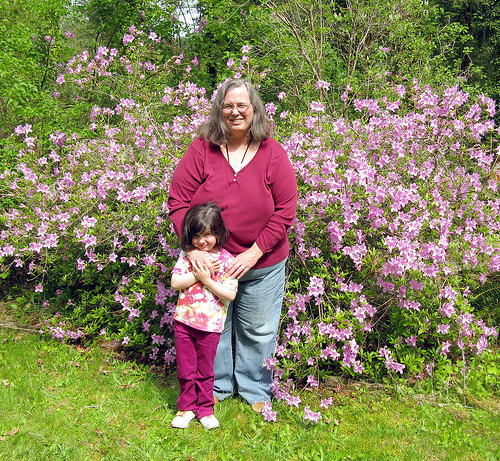

In [32]:
temp = test_df.sample(1).images.iloc[0]
Image.open(temp).convert("RGB")

In [33]:
tokenizer.decode(t.generate(feature_extractor(Image.open(temp).convert("RGB"), return_tensors="pt").pixel_values)[0])

'<s><s>a girl in a pink jacket is standing in a field of flowers <e></s>'